In [1]:
########################## 这个是最终的结果，之前的相关性写错了 ##############
#关于文档的一个数据分类
import pandas as pd
import seaborn as sns  #用于绘制热图的工具包
from scipy.cluster import hierarchy  #用于进行层次聚类，话层次聚类图的工具包
from scipy import cluster   
import matplotlib.pyplot as plt
from sklearn import decomposition as skldec #用于主成分分析降维的包
import numpy as np
#import csv
import math
from pandas import Series,DataFrame
from matplotlib.ticker import  MultipleLocator
import pylab as pl   #画图用
from sklearn import svm
from sklearn import linear_model
from scipy.cluster.hierarchy import fcluster

In [2]:
a = np.arange(2000,2018)
pop = [str(i)+'Pop' for i in a]
investment = [str(i)+'总投资金额(M)' for i in a]
inv_times = [str(i)+'总投资次数' for i in a]
gdp = [str(i)+'GDP' for i in a]

data =pd.read_excel('E:/vcdata/data/ALL_Intersection.xlsx')  # 读取训练数据
city=data['City'].drop_duplicates().values
City=data['city'].drop_duplicates().values

In [3]:
from scipy.optimize import leastsq  ##引入最小二乘法算法
#需要拟合的函数func :指定函数的形状
def func(p,x):
    k,b=p
    return k*x+b

##偏差函数：x,y都是列表:这里的x,y更上面的Xi,Yi中是一一对应的
def error(p,x,y):
    return func(p,x)-y

plt.rcParams['font.sans-serif']=['Simhei']     #解决中文显示问题，目前只知道黑体可行
plt.rcParams['axes.unicode_minus']=False       #解决负数坐标显示问题

##### 求残差 logy-log（kx+b）
def GuiJI(data,xl,yl,i,xname,yname):
    ###xl,yl：列名的list,xname,yname：列名,i:年份
    city=data['City'].drop_duplicates().values
    province=data['province'].values###得到省
    r=[]  ###标度率
    ###保存取完log后大于0的值
    p=[]
    g=[]
    ###取列值的log
    XI=data[xl[i]]
    YI=data[yl[i]]
    xi=np.log10(XI)
    yi=np.log10(YI)
    XII=xi.fillna(np.infty) ###将空值置为inf
    YII=yi.fillna(np.infty)
    ###判断是否大于0
    City=[]###保存log值大于0的城市名
    pro=[]###保存log值大于0的省名
    for mm in range(len(XII)):
        if XII[mm]==-float('Inf') or XII[mm]==float('Inf') or YII[mm]==-float('Inf') or YII[mm]==float('Inf'):
            continue
        else:
            p.append(XII[mm])
            g.append(YII[mm])
            City.append(city[mm])
            pro.append(province[mm])
                           
    #k,b的初始值，可以任意设定,经过几次试验，发现p0的值会影响cost的值：Para[1]
    p0=[1,10]
    Xi=np.array(p)
    Yi=np.array(g)
    #把error函数中除了p0以外的参数打包到args中(使用要求)
    Para=leastsq(error,p0,args=(Xi,Yi))## 三个参数：误差函数、函数参数列表、数据点
    #读取结果
    k,b=Para[0]
    ###将标度率写入r中
    r.append(k) 
    y = [k*x+b for x in p]
    ###得到残差
    sc=[g[v]-y[v] for v in range(len(g))]
    
    ###计算频率分布
    maxsc=max(sc)
    minsc=min(sc)
    Paragraph_len=(maxsc-minsc)/10
    fresc=[]###频率
    xvalue=[] ###坐标所在数段
    for i in range(10):###划分成10个段
        num=0
        psc=minsc+Paragraph_len*i ###左坐标
        rpsc=psc+Paragraph_len    ###右坐标
        for scj in sc:
            if scj>=psc and scj<rpsc:
                num=num+1
        fresc.append(num/len(City))
        xvalue.append((psc+rpsc)/2)
        
    ###按照sc的值进行排序
    scdic = list(zip(sc,City))
    scSort = sorted( scdic)###残差城市排序
    prodic = list(zip(sc,pro))
    proSort = sorted( prodic)
    return(r,City,p,g,y,sc,fresc,xvalue,scSort,k,b,proSort)

In [4]:
###让颜色匹配
Name_M=[1,2,3,4]
yj_color = {'1':(0.7247999999999999, 0.86, 0.33999999999999997),'2':(0.86, 0.3712, 0.33999999999999997),'3':'#FF9933','4':(0.33999999999999997, 0.5167999999999995, 0.86)}
vv = np.arange(1,27)
a=list(sns.color_palette("hls", 26))
yj_colorA={'1':a[15],'2':'#FF9933','3':(0.86, 0.3712, 0.33999999999999997)}###让amount显示不同的颜色
yj_colorT={'3':a[15],'2':'#FF9933','1':(0.86, 0.3712, 0.33999999999999997)}###让times显示不同的颜色
yj_colorG={'1':a[15],'3':'#FF9933','2':(0.86, 0.3712, 0.33999999999999997)}###让GMP显示不同的颜色

In [5]:
def getCity(s):
    a=list(s.split('|'))
    return(a[1])
data['province']=data.city.map(getCity)
province=data['province'].drop_duplicates().values###得到省
c=len(province)###一级产业数量

In [6]:
###热图
###每一个城市的残差的均值
### 相关性应该是 平方和开方为分母，连×之和为分子
def get_cij(scall,cityname):
    dfscyear = pd.DataFrame(scall, columns=cityname)###将每一年的残差转化为dataframe city*year
    ###求Cij
    Cij=[]
    for i in range(len(cityname)):
        c1=dfscyear[cityname[i]].values###得到城市1的残差
        c1Sum = 0
        for ccc in range(18):
            c1Sum += c1[ccc]**2 ###城市17年间残差平方连加
        lenc1 = math.sqrt(c1Sum)###得到分母
        #absc1=cityAvg[i]
        cij=[]
        for j in range(len(cityname)):
            c2=dfscyear[cityname[j]].values###得到城市2的残差
            addc12=0
            c2Sum = 0
            for c in range(18):
                mul=c1[c]*c2[c]
                addc12=addc12+mul
                c2Sum += c2[c]**2 ###城市17年间残差平方连加
            lenc2 = math.sqrt(c2Sum)###得到分母
            c12=addc12/(lenc1*lenc2)
            cij.append(c12)###两个城市cij
        Cij.append(cij)
    dfCij= pd.DataFrame(Cij)  
    return(dfCij)

In [7]:
########## 
cityM = GuiJI(data,pop,investment,15,'pop','amount')[1]###按照2015年含有投资金额的城市来删选2000-2016年间关于GDP\amount\times的数据
####查看一些城市2000-2016年的残差分布图
scall=[]###保存所有城市2000-2016年的残差
scallM=[]
scallT=[]
for i in range(18):    
    ### GDP残差
    sami=GuiJI(data,pop,gdp,i,'pop','GDP')
    sc=sami[5]###获取某一年的残差值
    cityname=sami[1]###城市名

    ###amount
    samiM=GuiJI(data,pop,investment,i,'pop','amount')
    scM=samiM[5]###获取某一年的残差值
    citynameM=samiM[1]###城市名

    ###times
    samiT=GuiJI(data,pop,inv_times,i,'pop','times')
    scT=samiT[5]###获取某一年的残差值
    citynameT=samiT[1]###城市名
 
    ### 删选出来含有投资的城市的GDP\TIMES
    sc_GDP0=[] ###保存含有投资的城市的GDP
    sc_amount0 = [] ###投资金额
    sc_times0=[] ###保存旱藕投资的城市的投资次数
    
    ### 1 得到GDP的数据
    for c1 in cityM:
        have = 0 ###标值该城市是否存在,0表示不存在
        for c2 in range(len(cityname)):
            if cityname[c2] == c1:
                sc_GDP0.append(sc[c2])
                have = 1
        if have == 0:
            sc_GDP0.append(0)
    ### 2 得到投资金额的数据
    for c1 in cityM:
        have1 = 0 ###标值该城市是否存在,0表示不存在
        for c2 in range(len(citynameM)):
            if citynameM[c2] == c1:
                sc_amount0.append(scM[c2])
                have1 = 1
        if have1 == 0:
            sc_amount0.append(0)
    ### 3 得到投资次数的残差数据
    for c1 in cityM:
        have2 = 0
        for c2 in range(len(citynameT)):
            if citynameT[c2] == c1:
                sc_times0.append(scT[c2])
                have2 = 1
        if have2 == 0:
            sc_times0.append(0)
            
    scallM.append(sc_amount0)###得到删选后的残差,城市和投资金额城市保持一致
    scallT.append(sc_times0)
    scall.append(sc_GDP0)

D:\Users\lu\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10


In [8]:
################ 得到相关性矩阵
dfAmount = get_cij(scallM,cityM)
dfTimes = get_cij(scallT,cityM)
dfGDP = get_cij(scall,cityM)

In [9]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
%matplotlib inline

In [10]:
#### 1. amount cij ####

In [11]:
ptd=(1-dfAmount)/2
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation
Z11 = linkage(ptd, 'ward')
end = 20
last = Z11[0:, 2]#Z的第三列
last_rev = last[::-1]#Z倒过来读
idxs = np.arange(1, len(last) + 1)
clusters_M3 = fcluster(Z11,3, criterion='maxclust')
# plt.hist(clusters_M3,bins=3)
cludfM3=pd.DataFrame()###保存城市和分类在dataframe,并将每一类分类对应不同颜色
dfCijM3=dfAmount
dfCijM3['cluster']=clusters_M3
clusterm3=sorted(dfCijM3['cluster'].drop_duplicates().values)
DATA3=[]###按照城市对数据进行分组
s3=[]
for li3 in clusterm3:
    dat3=dfCijM3[dfCijM3['cluster'].isin([li3])]
    DATA3.append(dat3)
    s3.append(dat3.shape[0])
    
dataM13=DATA3[0].append(DATA3[1])
dataM3=dataM13.append(DATA3[2])
dataM_23 = dataM3.drop(['cluster'], axis=1)##去除cluster列数据

### 按照列对相关性数据进行排序，先将dataframe转置，再按照行进行排序即可
dataM_33 = dataM_23.T ###转置
dataM_33['cluster']=clusters_M3
# clusterm=dfCijM['cluster'].drop_duplicates().values
DATA_col_M3 = []###按照城市对数据进行分组
s_col_M3 = []
for li in clusterm3:
    dat_col_M3 = dataM_33[dataM_33['cluster'].isin([li])]
    DATA_col_M3.append(dat_col_M3)
    s_col_M3.append(dat_col_M3.shape[0])
    
### 按照得到的分类数据进行排序
dataN1_col_M3=DATA_col_M3[0].append(DATA_col_M3[1])
dataN_col_M3=dataN1_col_M3.append(DATA_col_M3[2])

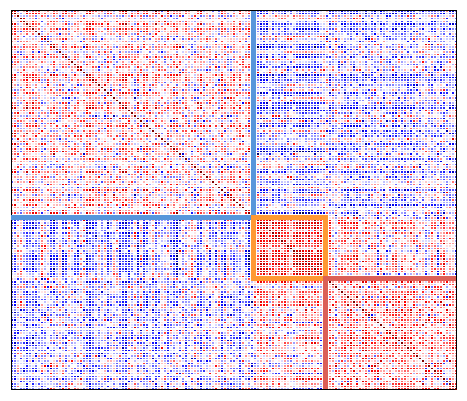

In [16]:
### 画出热图 
DFF23 = dataN_col_M3.drop(['cluster'], axis=1) ###将cluster列删除
l1 = s_col_M3[0]
l2 = s_col_M3[1]+l1
l3 = s_col_M3[2]+l2
f,ax1M3 = plt.subplots(figsize = (8,7))
cmap = plt.cm.get_cmap('seismic')
sns.heatmap(DFF23, linewidths = 0.05, ax = ax1M3, vmax=max(DFF23.max().values), vmin=min(DFF23.min().values), xticklabels=False, yticklabels=False, cmap=cmap,cbar =False)
plt.axvline(x=0,linestyle="-",color="black",linewidth=1)#添加垂直直线
plt.axhline(y=0,linestyle="-",color="black",linewidth=1)#添加垂直直线
plt.vlines(x=l1,linestyle="-",ymin=0,ymax=l1,color=yj_colorA['1'],linewidth=5)#添加垂直直线,#线起始位置
plt.vlines(x=l1,linestyle="-",ymin=l1,ymax=l2,color=yj_colorA['2'],linewidth=5)#添加垂直直线,#线起始位置
plt.vlines(x=l2,linestyle="-",ymin=l1,ymax=l2,color=yj_colorA['2'],linewidth=5)#添加垂直直线
plt.vlines(x=l2,linestyle="-",ymin=l2,ymax=l3,color=yj_colorA['3'],linewidth=5)#添加垂直直线
# plt.vlines(x=l3,linestyle="-",ymin=l2,ymax=l3,color=yj_colorA['3'],linewidth=5)#添加垂直直线

plt.plot(np.arange(0,l1+1),[l1 for xx in range(l1+1)],color=yj_colorA['1'],linewidth=5)###1
plt.plot(np.arange(l1,l2+1),[l1 for xx in range(l1,l2+1)],color=yj_colorA['2'],linewidth=5)
plt.plot(np.arange(l1,l2+1),[l2 for xx in range(l1,l2+1)],color=yj_colorA['2'],linewidth=5)###3
plt.plot(np.arange(l2,l3+1),[l2 for xx in range(l2,l3+1)],color=yj_colorA['3'],linewidth=5)###2
# plt.plot(np.arange(l2,l3+1),[l3 for xx in range(l2,l3+1)],color=yj_colorA['3'],linewidth=5)###4

plt.plot(np.arange(0,l3),[l3-0.5 for xx in range(l3)],color="black",linewidth=1)
plt.plot([l3-0.3 for xx in range(l3)],np.arange(0,l3),color="black",linewidth=1)
# plt.savefig('E:/vcdata/pic/picSC/Fig3_d_amount3.pdf', bbox_inches='tight')
# plt.savefig('E:/0论文/0picture/4_6a.png',dpi=500, bbox_inches='tight')

In [12]:
#### 2. # investments ####

In [12]:
###2.3
ptd=(1-dfTimes)/2
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation
Z11_T = linkage(ptd, 'ward')
end = 20
last = Z11_T[0:, 2]#Z的第三列
last_revT = last[::-1]#Z倒过来读
idxsT = np.arange(1, len(last) + 1)
# plt.plot(idxsT[:end], last_revT[:end])


clusters_T2 = fcluster(Z11_T,3, criterion='maxclust')
# plt.hist(clusters_T2,bins=3)

dfCijT2=dfTimes
dfCijT2['cluster']=clusters_T2
clusterT2=sorted(dfCijT2['cluster'].drop_duplicates().values)
aT2=list(sns.color_palette("hls", len(clusterT2)))
yj_colorT2=dict(zip(clusterT2,aT2)) ####将颜色和类别匹配
DATAT2=[]###按照城市对数据进行分组
sT2=[]
for li in clusterT2:
    dat=dfCijT2[dfCijT2['cluster'].isin([li])]
    DATAT2.append(dat)
    sT2.append(dat.shape[0])
    
dataT12=DATAT2[0].append(DATAT2[1])
# dataT2=DATAT[2].append(DATAT[3])
# dataM3=dataM2.append(DATA[4])
dataT2=dataT12.append(DATAT2[2])
dataT2_2 = dataT2.drop(['cluster'], axis=1)##去除cluster列数据

### 按照列对相关性数据进行排序，先将dataframe转置，再按照行进行排序即可
dataT_32 = dataT2_2.T ###转置
dataT_32['cluster']=clusters_T2
DATA_col_T2 = []###按照城市对数据进行分组
s_col_T2 = []
for li in clusterT2:
    dat_col_T2 = dataT_32[dataT_32['cluster'].isin([li])]
    DATA_col_T2.append(dat_col_T2)
    s_col_T2.append(dat_col_T2.shape[0])
    
### 按照得到的分类数据进行排序
dataN1_col_T2=DATA_col_T2[0].append(DATA_col_T2[1])
dataN_col_T2=dataN1_col_T2.append(DATA_col_T2[2])

In [19]:
clusters_T2

array([3, 3, 1, 1, 3, 1, 1, 2, 1, 3, 1, 3, 1, 1, 3, 3, 1, 3, 1, 3, 3, 2,
       2, 2, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 2, 3, 3, 1, 1, 3, 2,
       2, 3, 2, 3, 2, 1, 3, 3, 1, 1, 2, 2, 2, 3, 3, 1, 2, 2, 2, 3, 1, 1,
       1, 1, 3, 1, 2, 1, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 3, 1, 1, 2, 1,
       3, 1, 3, 2, 1, 3, 2, 1, 2, 2, 3, 3, 3, 3, 2, 3, 1, 3, 1, 2, 2, 1,
       2, 1, 1, 2, 3, 2, 2, 1, 1, 3, 1, 1, 2, 1, 3, 1, 3, 3, 1, 2, 2, 1,
       1, 1, 1, 3, 3, 2, 1, 3, 1, 3, 2, 1, 3, 2, 3, 3, 3], dtype=int32)

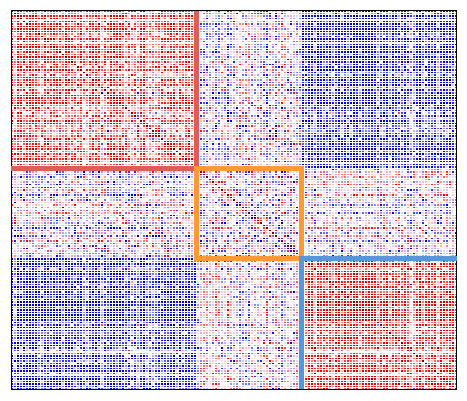

In [16]:
### 画出热图 
##### 得到先惯性的热图 ##########
DFF2T2 = dataN_col_T2.drop(['cluster'], axis=1) ###将cluster列删除
l1T = s_col_T2[0]
l2T = s_col_T2[1]+l1T
l3T = s_col_T2[2]+l2T

f,ax1T2= plt.subplots(figsize = (8,7))
cmap = plt.cm.get_cmap('seismic')
sns.heatmap(DFF2T2, linewidths = 0.05, ax = ax1T2, vmax=max(DFF2T2.max().values), vmin=min(DFF2T2.min().values), xticklabels=False, yticklabels=False, cmap=cmap,cbar =False)

plt.axvline(x=0,linestyle="-",color="black",linewidth=1)#添加垂直直线
plt.axhline(y=0,linestyle="-",color="black",linewidth=1)#添加垂直直线
plt.plot(np.arange(0,l3T),[l3T-0.5 for xx in range(0,l3T)],color="black",linewidth=1)
plt.plot([l3T-0.5 for xx in range(0,l3T+1)],np.arange(0,l3T+1),color="black",linewidth=1)

plt.vlines(x=l1T,linestyle="-",ymin=0,ymax=l1T,color=yj_colorT['1'],linewidth=5)#添加垂直直线,#线起始位置
plt.vlines(x=l1T,linestyle="-",ymin=l1T,ymax=l2T,color=yj_colorT['2'],linewidth=5)#添加垂直直线,#线起始位置
plt.vlines(x=l2T,linestyle="-",ymin=l1T,ymax=l2T,color=yj_colorT['2'],linewidth=5)#添加垂直直线
plt.vlines(x=l2T,linestyle="-",ymin=l2T,ymax=l3T,color=yj_colorT['3'],linewidth=5)#添加垂直直线

plt.plot(np.arange(0,l1T+1),[l1T for xx in range(l1T+1)],color=yj_colorT['1'],linewidth=5)###1
plt.plot(np.arange(l1T,l2T+1),[l1T for xx in range(l1T,l2T+1)],color=yj_colorT['2'],linewidth=5)
plt.plot(np.arange(l1T,l2T+1),[l2T for xx in range(l1T,l2T+1)],color=yj_colorT['2'],linewidth=5)###3
plt.plot(np.arange(l2T,l3T+1),[l2T for xx in range(l2T,l3T+1)],color=yj_colorT['3'],linewidth=5)###2
# plt.savefig('E:/vcdata/pic/picSC/Fig3_e_times3.pdf', bbox_inches='tight')
plt.savefig('E:/0论文/0picture/4_6b.png',dpi=500, bbox_inches='tight')

In [17]:
### 3. GMP ###

In [13]:
ptd_G=(1-dfGDP)/2
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation
Z11_G = linkage(ptd_G, 'ward')
end = 20
last_G = Z11_G[0:, 2]#Z的第三列
last_rev_G = last[::-1]#Z倒过来读
idxs_G = np.arange(1, len(last_G) + 1)
clusters_G3 = fcluster(Z11_G,3, criterion='maxclust')
# plt.hist(clusters_G3,bins=3)
dfCijG3=dfGDP
dfCijG3['cluster']=clusters_G3
clusterG3=sorted(dfCijG3['cluster'].drop_duplicates().values)

DATAG3=[]###按照城市对数据进行分组
sG3=[]
for li in clusterG3:
    dat3=dfCijG3[dfCijG3['cluster'].isin([li])]
    DATAG3.append(dat3)
    sG3.append(dat3.shape[0])
    
dataG13=DATAG3[0].append(DATAG3[1])
dataG3=dataG13.append(DATAG3[2])
dataG_23 = dataG3.drop(['cluster'], axis=1)##去除cluster列数据

### 按照列对相关性数据进行排序，先将dataframe转置，再按照行进行排序即可
dataG_33 = dataG_23.T ###转置
dataG_33['cluster']=clusters_G3
DATA_col_G3 = []###按照城市对数据进行分组
s_col_G3 = []
for li in clusterG3:
    dat_col_G3 = dataG_33[dataG_33['cluster'].isin([li])]
    DATA_col_G3.append(dat_col_G3)
    s_col_G3.append(dat_col_G3.shape[0])
    
### 按照得到的分类数据进行排序
dataN1_col_G3=DATA_col_G3[0].append(DATA_col_G3[1])
dataN_col_G3=dataN1_col_G3.append(DATA_col_G3[2])

In [21]:
clusters_G3

array([3, 2, 2, 1, 1, 3, 2, 3, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 3, 1, 1, 1,
       3, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1,
       2, 1, 3, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 3, 1, 1, 1, 2,
       2, 3, 1, 3, 1, 3, 1, 3, 2, 2, 1, 3, 3, 3, 1, 1, 2, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 3, 2, 3, 1, 2, 1, 3, 1, 2, 3,
       1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 2, 2, 1, 2, 3, 2, 2, 3, 2, 2,
       2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1], dtype=int32)

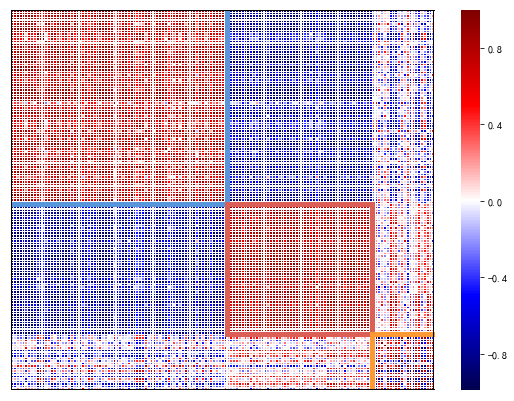

In [20]:
### 画出热图 
DFF2G3 = dataN_col_G3.drop(['cluster'], axis=1) ###将cluster列删除
l1G = s_col_G3[0]
l2G = s_col_G3[1]+l1G
l3G = s_col_G3[2]+l2G

f,ax1G3 = plt.subplots(figsize = (9.5,7))
cmap = plt.cm.get_cmap('seismic')
sns.heatmap(DFF2G3, linewidths = 0.05, ax = ax1G3, vmax=max(DFF2G3.max().values), vmin=min(DFF2G3.min().values), xticklabels=False, yticklabels=False, cmap=cmap)
plt.vlines(x=l1G,linestyle="-",ymin=0,ymax=l1G,color=yj_colorG['1'],linewidth=5)#添加垂直直线,#线起始位置
plt.vlines(x=l1G,linestyle="-",ymin=l1G,ymax=l2G,color=yj_colorG['2'],linewidth=5)#添加垂直直线,#线起始位置
plt.vlines(x=l2G,linestyle="-",ymin=l1G,ymax=l2G,color=yj_colorG['2'],linewidth=5)#添加垂直直线
plt.vlines(x=l2G,linestyle="-",ymin=l2G,ymax=l3G,color=yj_colorG['3'],linewidth=5)#添加垂直直线
# plt.vlines(x=l3G,linestyle="-",ymin=l2G,ymax=l3G,color=yj_colorG['3'],linewidth=5)#添加垂直直线
plt.plot(np.arange(0,l1G+1),[l1G for xx in range(l1G+1)],color=yj_colorG['1'],linewidth=5)###1
plt.plot(np.arange(l1G,l2G+1),[l1G for xx in range(l1G,l2G+1)],color=yj_colorG['2'],linewidth=5)
plt.plot(np.arange(l1G,l2G+1),[l2G for xx in range(l1G,l2G+1)],color=yj_colorG['2'],linewidth=5)###3
plt.plot(np.arange(l2G,l3G+1),[l2G for xx in range(l2G,l3G+1)],color=yj_colorG['3'],linewidth=5)###2
# plt.plot(np.arange(l2G,l3G+1),[l3G for xx in range(l2G,l3G+1)],color=yj_colorG['3'],linewidth=5)###4
# plt.plot(np.arange(l3G,l4G+1),[l3G for xx in range(l3G,l4G+1)],color=yj_color['4'],linewidth=5)

plt.axvline(x=0,linestyle="-",color="black",linewidth=1)#添加垂直直线
plt.axhline(y=0,linestyle="-",color="black",linewidth=1)#添加垂直直线
# plt.axvline(x=l3G,linestyle="-",color="black",linewidth=1)#添加垂直直线
# plt.axhline(y=l3G,linestyle="-",color="black",linewidth=1)#添加垂直直线
plt.plot(np.arange(0,l3G+1),[l3G-0.5 for xx in range(0,l3G+1)],color="black",linewidth=1)
plt.plot([l3G-0.5 for xx in range(0,l3G+1)],np.arange(0,l3G+1),color="black",linewidth=1)
# plt.savefig('E:/vcdata/pic/picSC/Fig3_f_GDP3.pdf', bbox_inches='tight')
plt.savefig('E:/0论文/0picture/4_6c.png',dpi=500, bbox_inches='tight')

In [43]:
# #### save the cluster
# dfcluster = pd.DataFrame(columns=['city','clusterA3','clusterT3','clusterG3'])
# dfcluster['city'] = cityM
# dfcluster['clusterA3'] = clusters_M3
# dfcluster['clusterT3'] = clusters_T2
# dfcluster['clusterG3'] = clusters_G3

# dfcluster = pd.read_excel('E:/vcdata/data/CijClass(2000-2017).xlsx')
# ####### 将经纬度和城市匹配####
# dataJW = pd.read_excel('E:/文档系列/python 系列/TheData/total/城市经纬度（baidu）.xlsx')
# JD = dataJW.set_index("City").to_dict()['Longitude']###得到2017年的city-gdp、pop、area、roadlength
# WD = dataJW.set_index("City").to_dict()['Latitude']
# def d1(s):
#     end=JD[s]
#     return(end)
# def d2(s):
#     end=WD[s]
#     return(end)
# dfcluster['Longitude']=dfcluster['city'].map(d1)###总表中的城市与其对应
# dfcluster['Latitude']=dfcluster['city'].map(d2)
# dfcluster.to_excel('E:/vcdata/data/CijClass(2000-2017).xlsx')

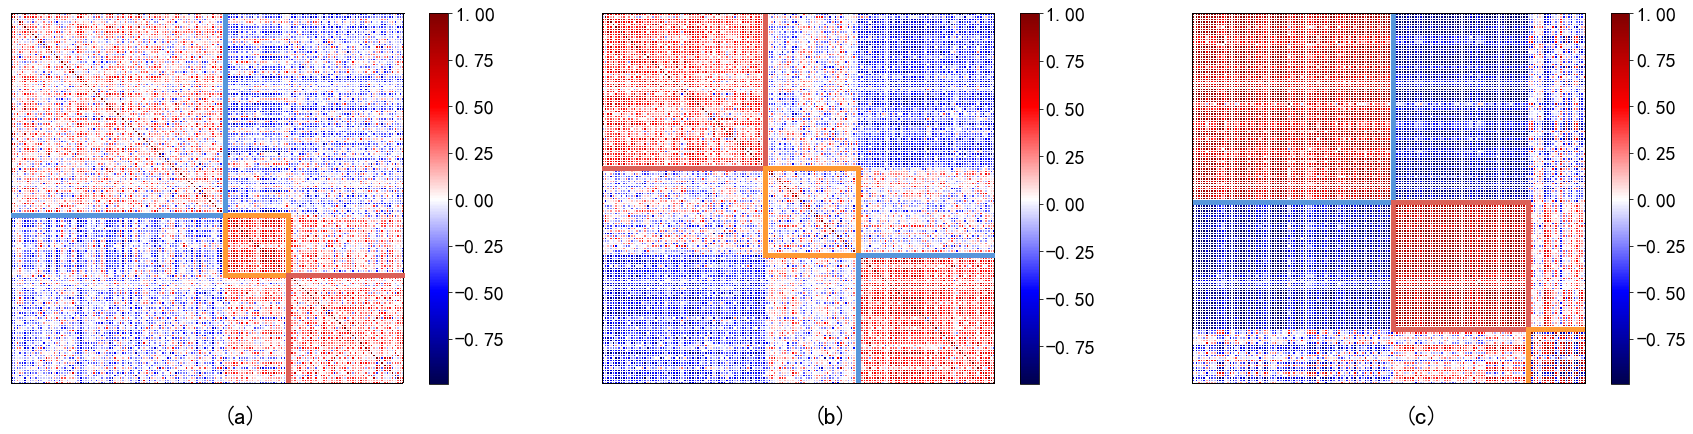

In [32]:
### 画出热图 
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(30,15))
# gs = gridspec.GridSpec(2, 4)
# gs.update(wspace=0.5)

DFF23 = dataN_col_M3.drop(['cluster'], axis=1) ###将cluster列删除
l1 = s_col_M3[0]
l2 = s_col_M3[1]+l1
l3 = s_col_M3[2]+l2
# f,ax1M3 = plt.subplots(figsize = (8,7))
# ax1M3 = plt.subplot(gs[0, 1:3])
ax1M3 = plt.subplot(231)
cmap = plt.cm.get_cmap('seismic')
h1=sns.heatmap(DFF23, linewidths = 0.05, ax = ax1M3, vmax=max(DFF23.max().values),
            vmin=min(DFF23.min().values), xticklabels=False, yticklabels=False, cmap=cmap,  annot_kws={"size":22},cbar =False)
cb1=h1.figure.colorbar(h1.collections[0]) #显示colorbar
cb1.ax.tick_params(labelsize=20)  #设置色标刻度字体大小。
plt.axvline(x=0,linestyle="-",color="black",linewidth=1)#添加垂直直线
plt.axhline(y=0,linestyle="-",color="black",linewidth=1)#添加垂直直线
plt.plot(np.arange(0,l3),[l3-0.5 for xx in range(l3)],color="black",linewidth=1)
plt.plot([l3-0.5 for xx in range(l3)],np.arange(0,l3),color="black",linewidth=1)
plt.vlines(x=l1,linestyle="-",ymin=0,ymax=l1,color=yj_colorA['1'],linewidth=5)#添加垂直直线,#线起始位置
plt.vlines(x=l1,linestyle="-",ymin=l1,ymax=l2,color=yj_colorA['2'],linewidth=5)#添加垂直直线,#线起始位置
plt.vlines(x=l2,linestyle="-",ymin=l1,ymax=l2,color=yj_colorA['2'],linewidth=5)#添加垂直直线
plt.vlines(x=l2,linestyle="-",ymin=l2,ymax=l3,color=yj_colorA['3'],linewidth=5)#添加垂直直线
# plt.vlines(x=l3,linestyle="-",ymin=l2,ymax=l3,color=yj_colorA['3'],linewidth=5)#添加垂直直线

plt.plot(np.arange(0,l1+1),[l1 for xx in range(l1+1)],color=yj_colorA['1'],linewidth=5)###1
plt.plot(np.arange(l1,l2+1),[l1 for xx in range(l1,l2+1)],color=yj_colorA['2'],linewidth=5)
plt.plot(np.arange(l1,l2+1),[l2 for xx in range(l1,l2+1)],color=yj_colorA['2'],linewidth=5)###3
plt.plot(np.arange(l2,l3+1),[l2 for xx in range(l2,l3+1)],color=yj_colorA['3'],linewidth=5)###2
# plt.plot(np.arange(l2,l3+1),[l3 for xx in range(l2,l3+1)],color=yj_colorA['3'],linewidth=5)###4
# plt.text(-15,5,'(a)',fontsize=24)
plt.text(80,165,'(a)',fontsize=24)

###########
### 画出热图 
##### 得到先惯性的热图 ##########
DFF2T2 = dataN_col_T2.drop(['cluster'], axis=1) ###将cluster列删除
l1T = s_col_T2[0]
l2T = s_col_T2[1]+l1T
l3T = s_col_T2[2]+l2T

# f,ax1T2= plt.subplots(figsize = (8,7))
# ax1T2 = plt.subplot(gs[1, :2], )
ax1T2 = plt.subplot(232)
cmap = plt.cm.get_cmap('seismic')
h2=sns.heatmap(DFF2T2, linewidths = 0.05, ax = ax1T2, vmax=max(DFF2T2.max().values),
            vmin=min(DFF2T2.min().values), xticklabels=False, yticklabels=False, cmap=cmap,cbar =False)
cb2=h2.figure.colorbar(h2.collections[0]) #显示colorbar
cb2.ax.tick_params(labelsize=20)  #设置色标刻度字体大小。
# plt.tick_params(labelsize=24) #设置colorbar刻度字体大小

plt.axvline(x=0,linestyle="-",color="black",linewidth=1)#添加垂直直线
plt.axhline(y=0,linestyle="-",color="black",linewidth=1)#添加垂直直线
plt.plot(np.arange(0,l3T),[l3T-0.5 for xx in range(0,l3T)],color="black",linewidth=1)
plt.plot([l3T-0.5 for xx in range(0,l3T+1)],np.arange(0,l3T+1),color="black",linewidth=1)

plt.vlines(x=l1T,linestyle="-",ymin=0,ymax=l1T,color=yj_colorT['1'],linewidth=5)#添加垂直直线,#线起始位置
plt.vlines(x=l1T,linestyle="-",ymin=l1T,ymax=l2T,color=yj_colorT['2'],linewidth=5)#添加垂直直线,#线起始位置
plt.vlines(x=l2T,linestyle="-",ymin=l1T,ymax=l2T,color=yj_colorT['2'],linewidth=5)#添加垂直直线
plt.vlines(x=l2T,linestyle="-",ymin=l2T,ymax=l3T,color=yj_colorT['3'],linewidth=5)#添加垂直直线

plt.plot(np.arange(0,l1T+1),[l1T for xx in range(l1T+1)],color=yj_colorT['1'],linewidth=5)###1
plt.plot(np.arange(l1T,l2T+1),[l1T for xx in range(l1T,l2T+1)],color=yj_colorT['2'],linewidth=5)
plt.plot(np.arange(l1T,l2T+1),[l2T for xx in range(l1T,l2T+1)],color=yj_colorT['2'],linewidth=5)###3
plt.plot(np.arange(l2T,l3T+1),[l2T for xx in range(l2T,l3T+1)],color=yj_colorT['3'],linewidth=5)###2
# plt.text(-15,5,'(b)',fontsize=24)
plt.text(80,165,'(b)',fontsize=24)
##########################
### 画出热图 
DFF2G3 = dataN_col_G3.drop(['cluster'], axis=1) ###将cluster列删除
l1G = s_col_G3[0]
l2G = s_col_G3[1]+l1G
l3G = s_col_G3[2]+l2G

# f,ax1G3 = plt.subplots(figsize = (9.5,7))
# ax1G3 = plt.subplot(gs[1, 2:])
ax1G3 = plt.subplot(233)
cmap = plt.cm.get_cmap('seismic')
h3 = sns.heatmap(DFF2G3, linewidths = 0.05, ax = ax1G3, vmax=max(DFF2G3.max().values),
            vmin=min(DFF2G3.min().values), xticklabels=False, yticklabels=False, cmap=cmap,cbar =False)

cb3=h3.figure.colorbar(h3.collections[0]) #显示colorbar
# cb3.ax.set_ticks([-1,-0.75,-0.5,-0.25,0, 0.25, 0.5,0.75, 1])
cb3.ax.tick_params(labelsize=20)  #设置色标刻度字体大小

plt.vlines(x=l1G,linestyle="-",ymin=0,ymax=l1G,color=yj_colorG['1'],linewidth=5)#添加垂直直线,#线起始位置
plt.vlines(x=l1G,linestyle="-",ymin=l1G,ymax=l2G,color=yj_colorG['2'],linewidth=5)#添加垂直直线,#线起始位置
plt.vlines(x=l2G,linestyle="-",ymin=l1G,ymax=l2G,color=yj_colorG['2'],linewidth=5)#添加垂直直线
plt.vlines(x=l2G,linestyle="-",ymin=l2G,ymax=l3G,color=yj_colorG['3'],linewidth=5)#添加垂直直线
# plt.vlines(x=l3G,linestyle="-",ymin=l2G,ymax=l3G,color=yj_colorG['3'],linewidth=5)#添加垂直直线
plt.plot(np.arange(0,l1G+1),[l1G for xx in range(l1G+1)],color=yj_colorG['1'],linewidth=5)###1
plt.plot(np.arange(l1G,l2G+1),[l1G for xx in range(l1G,l2G+1)],color=yj_colorG['2'],linewidth=5)
plt.plot(np.arange(l1G,l2G+1),[l2G for xx in range(l1G,l2G+1)],color=yj_colorG['2'],linewidth=5)###3
plt.plot(np.arange(l2G,l3G+1),[l2G for xx in range(l2G,l3G+1)],color=yj_colorG['3'],linewidth=5)###2
# plt.plot(np.arange(l2G,l3G+1),[l3G for xx in range(l2G,l3G+1)],color=yj_colorG['3'],linewidth=5)###4
# plt.plot(np.arange(l3G,l4G+1),[l3G for xx in range(l3G,l4G+1)],color=yj_color['4'],linewidth=5)

plt.axvline(x=0,linestyle="-",color="black",linewidth=1)#添加垂直直线
plt.axhline(y=0,linestyle="-",color="black",linewidth=1)#添加垂直直线
# plt.axvline(x=l3G,linestyle="-",color="black",linewidth=1)#添加垂直直线
# plt.axhline(y=l3G,linestyle="-",color="black",linewidth=1)#添加垂直直线
plt.plot(np.arange(0,l3G+1),[l3G-0.5 for xx in range(0,l3G+1)],color="black",linewidth=1)
plt.plot([l3G-0.5 for xx in range(0,l3G+1)],np.arange(0,l3G+1),color="black",linewidth=1)
# plt.text(-15,5,'(c)',fontsize=24)
plt.text(80,165,'(c)',fontsize=24)
plt.savefig('E:/0论文/2picture/3_5.png',dpi=500, bbox_inches='tight')
